In [11]:
import numpy as np
import tensorflow as tf

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [13]:
batch_size = 32
seed = 42

train_dir = "text_files_utf8_2"
# create a training dataset
train_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 44007 files belonging to 2 classes.
Using 35206 files for training.


In [14]:
# Create a validation set.
test_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 44007 files belonging to 2 classes.
Using 8801 files for validation.


In [15]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Bill: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Bill:  b'swanson  a bill to be entitled an act relating to use of an electronic device for accepting voters authorizing a fee be it enacted by the legislature of the state of texas subchaptera chapter31 election code is amended by adding  to read as follows certification of electronic devices to accept voters  the secretary of state shall prescribe specific requirements and standards consistent with this code for the certification of an electronic device used to accept voters under chapter63 that require the device to produce an electronic copy of the list of voters who were accepted to vote for delivery to the election judge after the polls close off-line display the voter \xe2\x80\x99s original signature accept a voter for voting even when the device is provide the full list of voters registered in the county with an indication of the jurisdictional or distinguishing number for each territorial unit in which each voter resides time-stamp when each voter is accepted at a polling place

In [48]:
for i, label in enumerate(test_dataset.class_names):
    print("Label", i, "corresponds to", label)

Label 0 corresponds to failed
Label 1 corresponds to passed


In [17]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  [b'  capriglione hb a noa a bill to be entitled an act relating to maintenance and production of electronic public information under the public information law be it enacted by the legislature of the state of texas section a(a-2) government code is amended to read as follows (a-2)  the definition of "public information" provided by subsection applies to and includes   any electronic communication created transmitted received or maintained on any device if the communication is in connection with the transaction of official business and   data dictionaries and other indicia of the type or category of information held in each field of a database section a  subchaptere chapter552 government code is amended by adding  to read as follows sec a  electronic public information  in this section"electronic public information" means public information that is produced and maintained in an electronic spreadsheet or database that is searchable or sortable   a governmental body \xe2\x80\x99 s 

### Create the text encoder

In [23]:
VOCAB_SIZE = 10000
max_length = 250
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=max_length)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'a', 'to', 'and', 'or', 'by', 'in',
       'for', 'is', 'an', 'as', 'that', 'this', 'under', 'code', 'be',
       'on'], dtype='<U22')

In [25]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[6657,  162,    4,  183,    4,   93,    5,   18,   74,   12,   29,
          71,    5,  318,    6,  862,    3,  436,   60,   69,   16,    2,
          60,   69,   49,   18,   70,   98,    8,    2,   68,    3,    2,
          22,    3,   33,   37,    1,   65,   17,   11,   31,    5,   34,
          13,   32,  931,    2, 1423,    3,   60,   69,   51,    8,   43,
         160,    5,    6,  406,   28,  436, 1064,  342, 3325,  321,    7,
         991,   19,   28,  612,   30,    2, 1064,   11,    9,  632,   24,
           2,  842,    3,  479,  142,    6,  553,    1,    6,   35,    1,
           3,    2,  714,    7, 1827,    3,   69,  340,    9,   50,  984,
           3,    4, 1632,   37,    4,  879, 2078,   65,   17,   11,   31,
           8,   81,    5,   34,   13,   32,  124,    4,  436,   60,   69,
           9,   15,    1,   60,   69,   82,   60,   69,   14,   11, 1604,
           6,  991,    9,   12,  436,    1,    7, 1632,   14,   11, 6372,
           7,    1,    4,  363,  279, 

In [29]:
len(encoded_example[2])

250

In [30]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'  capriglione hb a noa a bill to be entitled an act relating to maintenance and production of electronic public information under the public information law be it enacted by the legislature of the state of texas section a(a-2) government code is amended to read as follows (a-2)  the definition of "public information" provided by subsection applies to and includes   any electronic communication created transmitted received or maintained on any device if the communication is in connection with the transaction of official business and   data dictionaries and other indicia of the type or category of information held in each field of a database section a  subchaptere chapter552 government code is amended by adding  to read as follows sec a  electronic public information  in this section"electronic public information" means public information that is produced and maintained in an electronic spreadsheet or database that is searchable or sortable   a governmental body \xe2\x80\x99

In [40]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [41]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [42]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.01233377]


In [43]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 31ms/step
[0.01233377]


In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [45]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
1101/1101 [==============================] - 192s 168ms/step - loss: 0.4855 - accuracy: 0.8129 - val_loss: 0.4456 - val_accuracy: 0.8219
Epoch 2/10
1101/1101 [==============================] - 182s 165ms/step - loss: 0.4381 - accuracy: 0.8129 - val_loss: 0.4462 - val_accuracy: 0.8219
Epoch 3/10
1101/1101 [==============================] - 185s 168ms/step - loss: 0.4056 - accuracy: 0.8139 - val_loss: 0.4471 - val_accuracy: 0.8240
Epoch 4/10
1101/1101 [==============================] - 183s 166ms/step - loss: 0.3789 - accuracy: 0.8212 - val_loss: 0.4631 - val_accuracy: 0.8260
Epoch 5/10
1101/1101 [==============================] - 182s 165ms/step - loss: 0.3556 - accuracy: 0.8305 - val_loss: 0.4724 - val_accuracy: 0.8135
Epoch 6/10
1101/1101 [==============================] - 210s 191ms/step - loss: 0.3371 - accuracy: 0.8382 - val_loss: 0.5130 - val_accuracy: 0.8146
Epoch 7/10
1101/1101 [==============================] - 190s 172ms/step - loss: 0.3207 - accuracy: 0.8481 - val_

In [55]:
y_new = model.predict(test_dataset)

276/276 [==============================] - 14s 49ms/step


In [56]:
import numpy as np
import math

# custom function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

y_new = sigmoid_v(np.array([y_new]))
print(y_new[0:5])

[[[0.82366778]
  [0.00143548]
  [0.01715074]
  ...
  [0.06942293]
  [0.02976816]
  [0.39823804]]]


In [59]:
pred_labels = []
for val in y_new:
    for y in val:
        if .5 <= y:
            pred_labels.append(1)
        elif y < .5:
            pred_labels.append(0)
        else: 
            print("could not get prediction")

In [69]:
len(pred_labels)

8801

In [46]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

276/276 [==============================] - 23s 83ms/step - loss: 0.5409 - accuracy: 0.8009
Test Loss: 0.5408532023429871
Test Accuracy: 0.8009316921234131


(0.0, 0.5965682730078697)

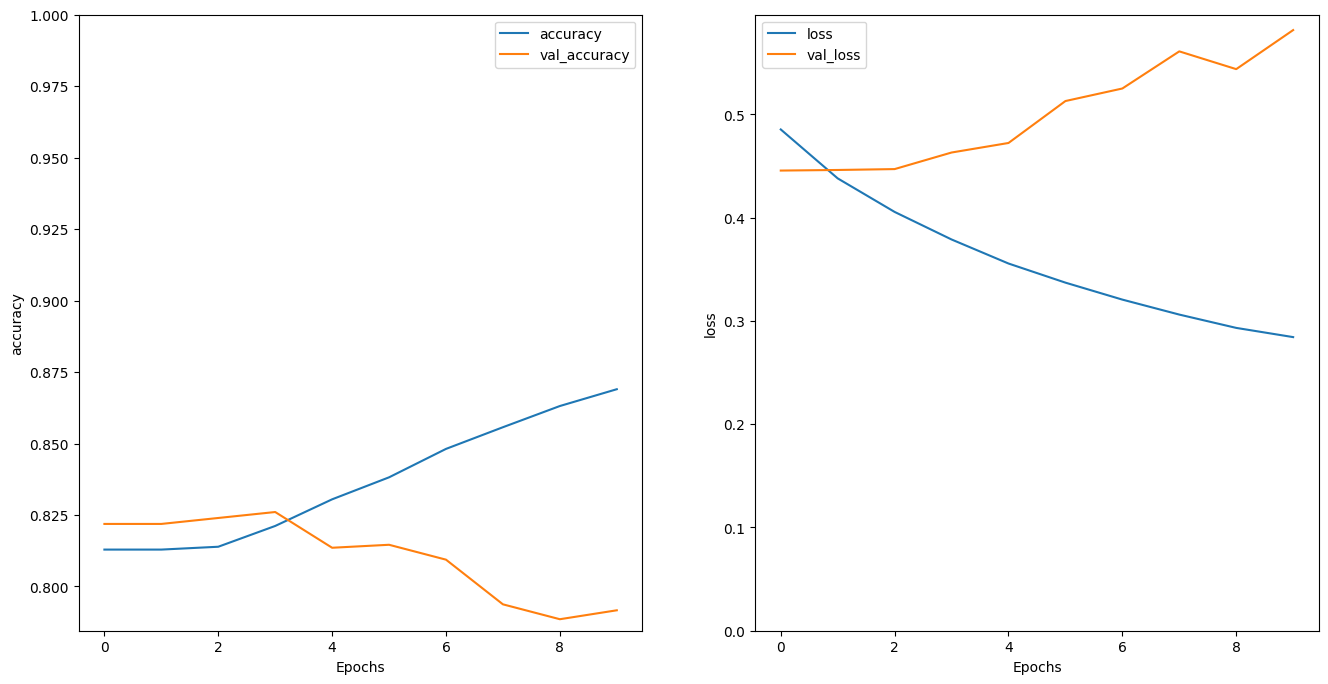

In [47]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [66]:
test_labels = []
for _, labels in test_dataset:
    print(labels.numpy())
    for label in labels.numpy():
        test_labels.append(label)

[0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1]
[1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0]
[0 0 1 0 0

[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
[0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
[0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]
[1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
[1 1 1 0 0

In [68]:
len(test_labels)

8801

In [70]:
confusion = tf.confusion_matrix(labels=test_labels, 
                                predictions=pred_labels, num_classes=2) 

AttributeError: module 'tensorflow' has no attribute 'confusion_matrix'

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels, 
                      labels=[0, 1])

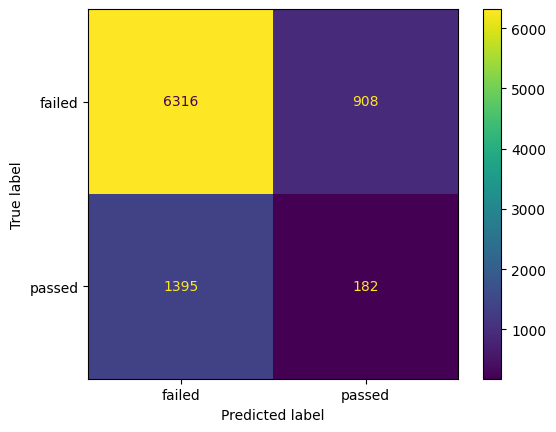

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["failed", "passed"])
disp.plot()
plt.show()